# TODO

1. Fit (RNN? big data time series model) using socioeconomic variables per country
1. Look into running simulations (e.g. 3b1b etc.)
1. Consider using a branching process model
    1. Continuous time
    1. Discrete time

# DONE

1. Research reinfection rates (is it worth using a model without reinfection?)

    Some studies suggest prior infection is 80% effective, so maybe it is worth using a model which removes people after infection
    
1. Fit using alternative cost function and to a grid of initial coords

    Improved rigour and reduced error due to initial data estimates
    
1. Figure out what data sources are available for Australia and what data they have
    1. Consider using a different country
        Can use data for all countries, using socioeconomic variables as inputs
    1. Consider using LGA/post code level data for some sort of varied model
        Data is available in Australia, but also is harder to deal with

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from math import floor
import ode
import pandas as pd
import seaborn as sns

# Model 1 (SIS model to Aus data with vaccine proportion)

## Set up input data

### Read SI data

Confirmed
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '12/23/21', '12/24/21', '12/25/21', '12/26/21', '12/27/21', '12/28/21',
       '12/29/21', '12/30/21', '12/31/21', '1/1/22'],
      dtype='object', length=711)
Index(['Province/State', 'Country/Region', 'Lat', 'Long'], dtype='object')

Recovered
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '12/23/21', '12/24/21', '12/25/21', '12/26/21', '12/27/21', '12/28/21',
       '12/29/21', '12/30/21', '12/31/21', '1/1/22'],
      dtype='object', length=711)
Index(['Province/State', 'Country/Region', 'Lat', 'Long'], dtype='object')

Dead
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '12/23/21', '12/24/21', '12/25/21', '12/26/21', '12/27/21', '12/28/21',
     

<AxesSubplot:xlabel='Date'>

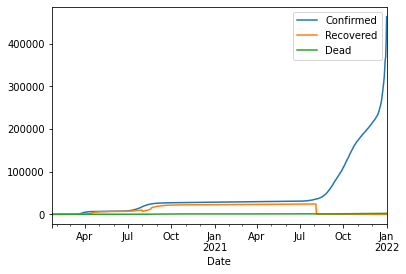

In [2]:
si_df = None
for col in ['Confirmed', 'Recovered', 'Dead']:
    
    # Read data and filter for Australia
    sidf = pd.read_csv(f'data/{col}.csv') 
    sidf = sidf[sidf['Country/Region'] == 'Australia']
    
    # Pivot dates
    print(col)
    print(sidf.columns[4:]) 
    print(sidf.columns[:4])
    id_cols = sidf.columns[:4]
    print()

    sidf = sidf.melt(id_vars = id_cols, var_name = 'Date', value_name = col)
    sidf = sidf[['Province/State', 'Date', col]] 
    
    # Aggregate to national level and set date index
    sidf = sidf.groupby('Date')[col].sum().reset_index() 
    sidf['Date'] = pd.to_datetime(sidf['Date'], format='%m/%d/%y')
    sidf = sidf.sort_values('Date').set_index('Date')
    
    # Add to output
    if si_df is None:
        si_df = sidf
    else:
        si_df = si_df.join(sidf)
    
# Check output
#si_df.to_csv('check.csv')
si_df.plot()

### Read vaccination data

            Vaccinated
Date                  
2021-03-18         206
2021-03-19         340
2021-03-20         467
2021-03-21         467
2021-03-22         467


<AxesSubplot:xlabel='Date'>

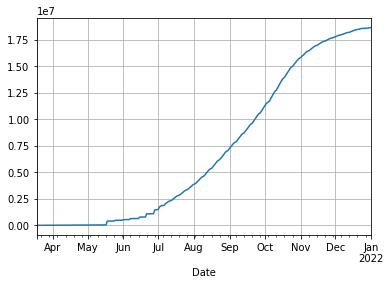

In [3]:
# Read data
vdf = pd.read_csv('data/v_ts.csv')

# Set datetime index
vdf['Date'] = pd.to_datetime(vdf['Date'], format="%d/%m/%Y")
vdf = vdf.sort_values(by='Date').set_index('Date') 

# Aggregate to national level
list_of_states = ['NSW','VIC','QLD','SA','WA','TAS','NT','ACT']
vdf['Vaccinated'] = vdf.loc[:,list_of_states].sum(axis=1)

# Check
vdf = vdf[['Vaccinated']] 

print(vdf.head()) 
vdf['Vaccinated'].plot(grid=True)  

### Join datasets to get input data for model

<AxesSubplot:xlabel='Date'>

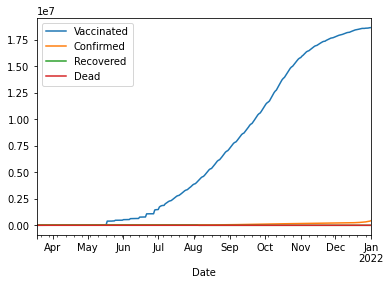

In [4]:
df_siv = vdf.join(si_df)
df_siv.plot()
#df_siv = df_siv['2021-05-01':'2021-08-04']
#df_siv.plot() 

## Fit model

      fun: 585732.3555271113
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-10.97796485,   0.        ,  10.98960645, -14.63340604])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([0.1351948 , 0.29829926, 7.11365626, 3.80035682])


<AxesSubplot:xlabel='Date'>

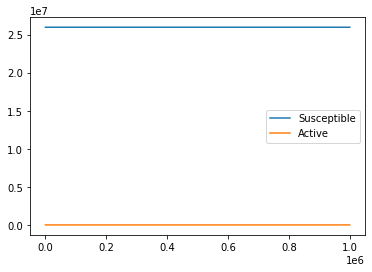

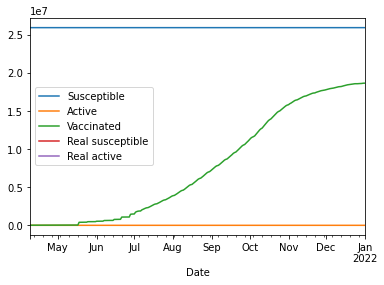

In [5]:
auspop = 25954112

vac=df_siv['Vaccinated'].values
#active = df_siv['Confirmed'].values - df_siv['Recovered'].values
active = df_siv['Confirmed'] - df_siv['Confirmed'].shift(periods=22)
sus = auspop-active 

active = active[22:]
sus = sus[22:]
vac = vac[22:]

def get_vac(t):
    val = floor(t)
    last = len(vac)-1
    return vac[min(val, last)]

def simodel(y, t, p): 
    bu, bv, gu, gv = p 
    s, i = y 
    vt = get_vac(t) 
    flow = ((auspop-vt)/(auspop))*(-bu*s*i/auspop +gu*i) + (vt/(auspop))*(-bv*s*i/auspop +gv*i)  
    return [flow, -flow]

def fit_simodel(p, ynought, tvec):
    m_with_params = lambda y, t: simodel(y,t,p)
    return odeint(m_with_params, ynought, tvec)

tv = [x for x in range(len(vac))] 
y0 = [sus[0], active[0]] 

def f_resid(p):  
    fitted = fit_simodel(p, y0, tv)
    return np.linalg.norm(sus-fitted[:,0]) 

fitted = minimize(f_resid, 
                  [1,.3,1/25,1/25], 
                  method='L-BFGS-B',
                  bounds=((0,None), (0,None), (0,None), (0,None)))
print(fitted)

results = fit_simodel(fitted.x, y0, [x for x in range(1000000)])  
df = pd.DataFrame(results, columns = ['Susceptible', 'Active'])  
df[['Susceptible', 'Active']].plot()  

results = fit_simodel(fitted.x, y0, tv)
df = pd.DataFrame(results, columns = ['Susceptible', 'Active'])
df['Date'] = df_siv.index[22:]
df['Vaccinated'] = vac
df['Real susceptible'] = sus
df['Real active'] = active
df = df.set_index('Date')
df.plot() 

### Simplified model fit

      fun: 311293.72548483155
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 205.25767479, 5119.32885544])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 216
      nit: 15
     njev: 72
   status: 0
  success: True
        x: array([0.07949328, 0.06537922])

Fitting model

beta=0.07949328147706451, gamma=0.06537922094854555
steady state: 4605633.838808925 cases


Trying custom values

beta=0.1, gamma=0.07142857142857142
steady state: 7415460.567553406 cases



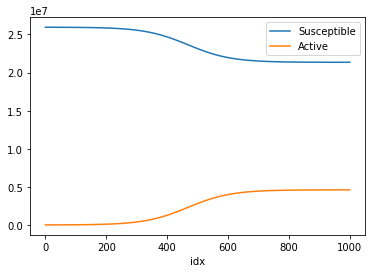

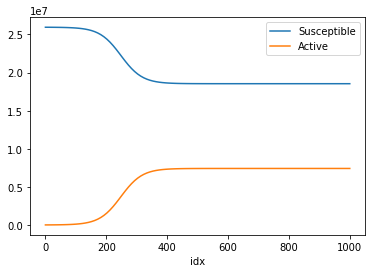

In [6]:
auspop = 25954112
 
active = df_siv['Confirmed'].values - df_siv['Recovered'].values
sus = auspop-active  

def simodel(y, t, p): 
    b, g = p 
    s, i = y 
    flow = -b*s*i/auspop +g*i 
    return [flow, -flow]

def fit_simodel(p, times, ynought):
    m_with_params = lambda y, t: simodel(y,t,p)
    return odeint(m_with_params, ynought, times)

tv = [x for x in range(len(active))] 
y0 = [sus[0], active[0]]

def f_resid(p):  
    fitted = fit_simodel(p, tv, y0)
    return np.linalg.norm(sus-fitted[:,0])

fitted = minimize(f_resid, [1,1/100], method='L-BFGS-B', bounds = ((0,None), (0, None)))
print(fitted) 

t_new = np.linspace(0,1000,100)

def plot_model(params):
    fitted_model = pd.DataFrame(fit_simodel(params, t_new, y0), columns = ['Susceptible','Active'])
    fitted_model['idx'] = t_new
    fitted_model = fitted_model.set_index('idx')
    fitted_model.plot()
    print(f'\nbeta={params[0]}, gamma={params[1]}')
    print(f'steady state: {max(fitted_model["Active"])} cases\n')

print('\nFitting model')
plot_model(fitted.x)
print('\nTrying custom values')
plot_model([.1,1/14])

## Discussion of Model 1
* Data was quite bad
    * Look at alternative data
    * Perhaps we can use location granularity somehow
    * Would it be easier to model a different country, or the original COVID outbreak (in 2020)?
* Model structure may have been off
    * Could look into reinfection rates and possibility of a SEIR model or something
        * Would need to get data to apply
        
        Vaccines protect against reinfection more than being previously infected, although in general reinfection is very possible
        
        
* Could look at just running simulations without having to fit to data

# Model 2 (Alternative data, SEIR model)

## Plan
1. Load data
1. Generate features (susceptible, exposed, infected, recovered)
    1. Have to estimate recovered
1. Fit model

## Load data

In [7]:
owiddf = pd.read_csv('data/owid-covid-data.csv')

owiddf = owiddf[owiddf['location'] == 'Australia']
owiddf['date'] = pd.to_datetime(owiddf['date'], format='%Y-%m-%d')
owiddf = owiddf.set_index('date')

features = owiddf[['total_cases']].rename(columns={'total_cases':'susceptible'})

# susceptible = population - people that have been infected
features.loc[:,'susceptible'] = auspop - features['susceptible']

# estimate exposed as number of cases in last 5 days (mean incubation time is 5 days)
features.loc[:,'exposed'] = owiddf['total_cases'] - \
    owiddf['total_cases'].shift(periods=5)

# estimate recovered as cases >= 22 days old (mean recovery time is 22 days)
features.loc[:,'recovered'] = owiddf['total_cases'].shift(periods=22)

# estimate infectious as remainder of population
features.loc[:,'infectious'] = auspop - \
    features[['exposed','recovered','susceptible']] \
    .sum(axis=1)

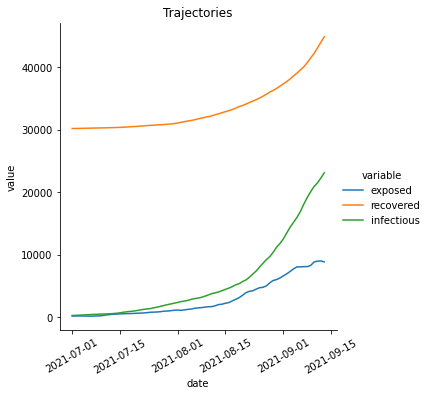

In [8]:
    #.loc['2021-12-05':,:] \
plotdf = features.copy() \
    .loc['2021-07':'2021-9-13',:] \
    .reset_index() \
    .melt(id_vars='date', value_vars=['exposed', 'recovered', 'infectious'])
    #.melt(id_vars='date', value_vars=['susceptible','exposed', 'recovered', 'infectious'])

start = '2021-07'
end = '2021-9-13'

g = sns.relplot(x='date', 
                y="value", 
                hue="variable", 
                kind="line", 
                data=plotdf)
g.set_xticklabels(rotation=30)
g.set(title='Trajectories')

[25923428.0, 185.0, 274.0, 30225.0]


<AxesSubplot:xlabel='date'>

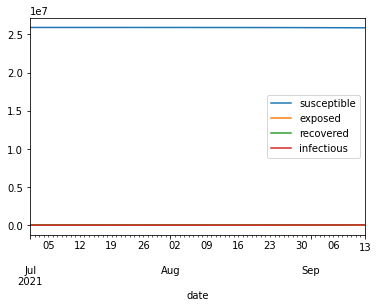

In [9]:
# outbreak has been selected. Next step is to calculate features
features = features.loc[start:end]
print(features.loc['2021-07-01', ['susceptible', 'exposed', 'infectious', 'recovered']].values.flatten().tolist())
features.plot()


## Fitting model

In [1]:
# Compute gradient as a function of t and y(t), with parameters p as an input
def seirmodel(y, t, p):
    s, e, i, r = y
    #mu, beta, a, gamma = p
    beta, a, gamma = p
    # death rate = 6.7 per 1000 per capita
    mu = 6.7/(1000*365)
    dsdt = mu*auspop - mu*s - beta*i*s/auspop
    dedt = beta*i*s/auspop - (mu+a)*e
    didt = a*e - (gamma+mu)*i
    drdt = gamma*i - mu*r
    return [dsdt, dedt, didt, drdt]

# Return case predictions using the above model given initial conditions and parameters
def run_seirmodel(y_0, t_0, p):
    model_partial = lambda y, t: seirmodel(y, t, p)
    return odeint(model_partial, y_0, t_0)

# Compute residuals given parameters
def resid_seirmodel(y_0, t_0, s, p):
    fitted = run_seirmodel(y_0, t_0, p)
    #return np.linalg.norm(s - fitted[:,0])
    # alternative cost function - give higher weighting to later observations (linearly)
    linear_weights = np.exp(np.linspace(0,1,len(t_0)))
    weighting = linear_weights/(np.linalg.norm(linear_weights)**0.5)
    return np.linalg.norm((s - fitted[:, 0]) * weighting)


y_initial = features.loc[
        '2021-07-01', 
        ['susceptible', 'exposed', 'infectious', 'recovered']
    ] \
            .values.flatten().tolist()

# times for fitting (each day)
t_initial = [x for x in range(len(features.index))]
# times for predicting (next 2.8 years)
t_predict = np.linspace(0, 1000, 1000)

# fit estimates on a list
base_est_list = np.mgrid[0:5:3j, 0:1/2:3j, 0:.6:2j].T.reshape(-1, 3)
fitted = None
for est in base_est_list:
    print(f'testing beta={est[0]}, a={est[1]}, gamma={est[2]}')
    fitted_new = minimize(
        lambda p: resid_seirmodel(
            y_initial,
            t_initial,
            features['susceptible'],
            p
        ),
        est,
        method ='L-BFGS-B',
        bounds = ((0, None), (0, None), (0, None))
    )
    if fitted is None or fitted_new.fun < fitted.fun:
        if fitted is None:
            print(f'first error = {fitted_new.fun}')
        else:
            print(f'beat previous result of {fitted.fun} by {fitted.fun-fitted_new.fun}')
        fitted = fitted_new
        
print(fitted) 

def fit_seirmodel(t):
    return pd.DataFrame(
        run_seirmodel(y_initial, t, fitted.x),
        columns = ['susceptible', 'exposed', 'infectious', 'recovered']
    )

full_cols = ['susceptible', 'exposed', 'infectious', 'recovered']

plt.figure()
fit_seirmodel(t_predict).plot()
plt.show()

plt.figure()
fit_seirmodel(t_predict)[full_cols[1:3]].plot() 
plt.show()

new_cases_daily = fit_seirmodel(t_predict)[['exposed','infectious']].sum(axis=1).diff()
plt.figure()
plt.plot(t_predict, new_cases_daily)
plt.show()

plt.figure()
fit_seirmodel(t_initial)[full_cols[1:]].plot()
plt.show()

plt.figure()
features.loc[:, ['exposed', 'infectious', 'recovered']].plot()
plt.show()

# get day of peak
print(
    fit_seirmodel(t_predict) \
    .index[
        np.where(
            fit_seirmodel(t_predict)['infectious'] == \
            max(fit_seirmodel(t_predict)['infectious']))
    ]
)

print(
    new_cases_daily.index[np.where(new_cases_daily == np.nanmax(new_cases_daily))]
)

NameError: name 'features' is not defined

# Model 3 (ARIMA + exogenous)

## Plan
1. Load COVID data
1. Join to public holidays + weekdays
1. Select ARIMA parameters (with pub hols + weekdays as parameters)
1. Cross validate model
1. Train to forecast

## Load data

In [20]:
owiddf = pd.read_csv('data/owid-covid-data.csv')
owiddf = owiddf[owiddf['location'] == 'Australia']
owiddf['date'] = pd.to_datetime(owiddf['date'], format='%Y-%m-%d')
owiddf = owiddf.set_index('date')
owiddf['weekday'] = owiddf.index.weekday
owiddf.head()

iso_code continent   location  total_cases  new_cases  \
date                                                               
2020-01-26      AUS   Oceania  Australia          4.0        4.0   
2020-01-27      AUS   Oceania  Australia          5.0        1.0   
2020-01-28      AUS   Oceania  Australia          5.0        0.0   
2020-01-29      AUS   Oceania  Australia          6.0        1.0   
2020-01-30      AUS   Oceania  Australia          9.0        3.0   

            new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
date                                                                            
2020-01-26                 NaN           NaN         NaN                  NaN   
2020-01-27                 NaN           NaN         NaN                  NaN   
2020-01-28                 NaN           NaN         NaN                  NaN   
2020-01-29                 NaN           NaN         NaN                  NaN   
2020-01-30                 NaN           NaN         NaN                  NaN   

            total_cases_per_million  ...  male_smokers  \
date                                 ...                 
2020-01-26                    0.155  ...          16.5   
2020-01-27                    0.194  ...          16.5   
2020-01-28                    0.194  ...          16.5   
2020-01-29                    0.233  ...          16.5   
2020-01-30                    0.349  ...          16.5   

            handwashing_facilities  hospital_beds_per_thousand  \
date                                                             
2020-01-26                     NaN                        3.84   
2020-01-27                     NaN                        3.84   
2020-01-28                     NaN                        3.84   
2020-01-29                     NaN                        3.84   
2020-01-30                     NaN                        3.84   

            life_expectancy  human_development_index  \
date                                                   
2020-01-26            83.44                    0.944   
2020-01-27            83.44                    0.944   
2020-01-28            83.44                    0.944   
2020-01-29            83.44                    0.944   
2020-01-30            83.44                    0.944   

            excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
date                                                                            
2020-01-26                                -532.6                        -4.47   
2020-01-27                                   NaN                          NaN   
2020-01-28                                   NaN                          NaN   
2020-01-29                                   NaN                          NaN   
2020-01-30                                   NaN                          NaN   

            excess_mortality  excess_mortality_cumulative_per_million  weekday  
date                                                                            
2020-01-26             -0.48                               -20.652843        6  
2020-01-27               NaN                                      NaN        0  
2020-01-28               NaN                                      NaN        1  
2020-01-29               NaN                                      NaN        2  
2020-01-30               NaN                                      NaN        3  

[5 rows x 67 columns]